# Random Walk Simulation 

This notebook demonstrates a random walk simulation, analyzes market data, back-tests stock strategies, and applies risk management strategies.

# Usage Guide for White Noise Process Study

## Introduction
This notebook provides a step-by-step guide on how to use the code provided in this repository for studying the White Noise Process. We will cover the following topics:
1. Setting up the environment
2. Generating Random Walk
3. Fitting an ARIMA Model
4. Monte Carlo Simulation of Random Walk
5. Running a SPY Trend-following strategy

## 1. Setting Up the Environment
First, ensure you have all the necessary libraries installed. You can install the required dependencies by running:

%pip install numpy pandas matplotlib scipy statsmodels tqdm yfinance 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import time
import yfinance as yf
import os
from scipy import stats

CONFIDENCE_LEVEL = 0.95

## Loading the Data
Next, we will load the data used in the analysis. The data should be placed in the `data` directory. For this example, we'll assume the data is in a CSV file named `white_noise_data.csv`.

In [2]:
import pandas as pd

# Load the data
data = pd.read_csv('data/white_noise_data.csv')
data.head()

,WhiteNoise
0,0.496714
1,-0.138264
2,0.647689
3,1.523030
4,-0.234153


## 2. Generating Random Walk

We'll start by generating a random walk with a specified number of steps, mean, and standard deviation.

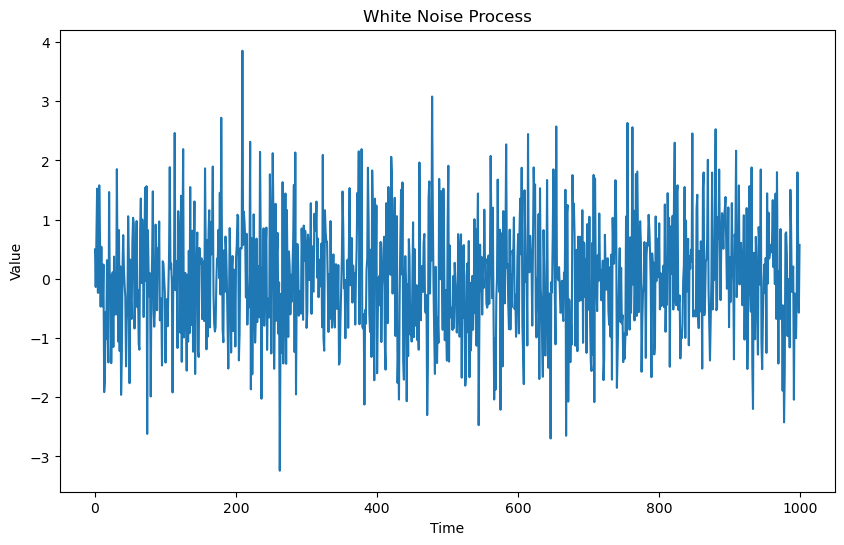

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_walk(n=1000, mean=0, std_dev=1):
    return np.cumsum(np.random.normal(mean, std_dev, n))

# Generate random walk
n = 1000
random_walk = generate_random_walk(n=n)
random_walk

# Generate white noise
np.random.seed(42)
white_noise = np.random.normal(0, 1, 1000)

# Plot the white noise
plt.figure(figsize=(10, 6))
plt.plot(white_noise)
plt.title('White Noise Process')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

## Simulating Multiple Random Walk Paths

Using the generated random walk, we'll simulate multiple paths.

In [9]:
def monte_carlo_simulation(num_simulations=1000, n=1000, mean=0, std_dev=1):
    simulated_series = []
    for _ in tqdm(range(num_simulations), desc="Monte Carlo Simulation"):
        simulated_series.append(generate_random_walk(n, mean, std_dev))
    return np.array(simulated_series)

# Perform Monte Carlo simulation
num_simulations = 1000
simulated_series = monte_carlo_simulation(num_simulations=num_simulations, n=n)
simulated_series

Monte Carlo Simulation: 100%|██████████| 1000/1000 [00:00<00:00, 14965.76it/s]


array([[ 1.39935544e+00,  2.32398912e+00,  2.38361949e+00, ...,
         7.17442069e+01,  7.15811399e+01,  7.08362372e+01],
       [-6.75178275e-01, -8.19696946e-01, -1.61211687e+00, ...,
         5.65529719e+00,  5.98947360e+00,  5.83421456e+00],
       [-1.90780756e+00, -2.76819257e+00, -3.18179810e+00, ...,
        -2.07232438e+01, -1.90798657e+01, -1.87192178e+01],
       ...,
       [-6.16193461e-01, -1.60972412e+00,  9.07347745e-01, ...,
        -5.44795552e+01, -5.51406706e+01, -5.47771161e+01],
       [-1.37456855e+00, -1.98391296e+00, -1.39272919e+00, ...,
        -6.21271294e+01, -6.06579871e+01, -6.01815568e+01],
       [ 1.69171855e-01,  4.76666991e-02,  1.20429197e+00, ...,
         3.74174261e+01,  3.77408876e+01,  3.57048274e+01]])

## Plotting the Simulation Results

Finally, we'll plot the results of our Monte Carlo simulation.

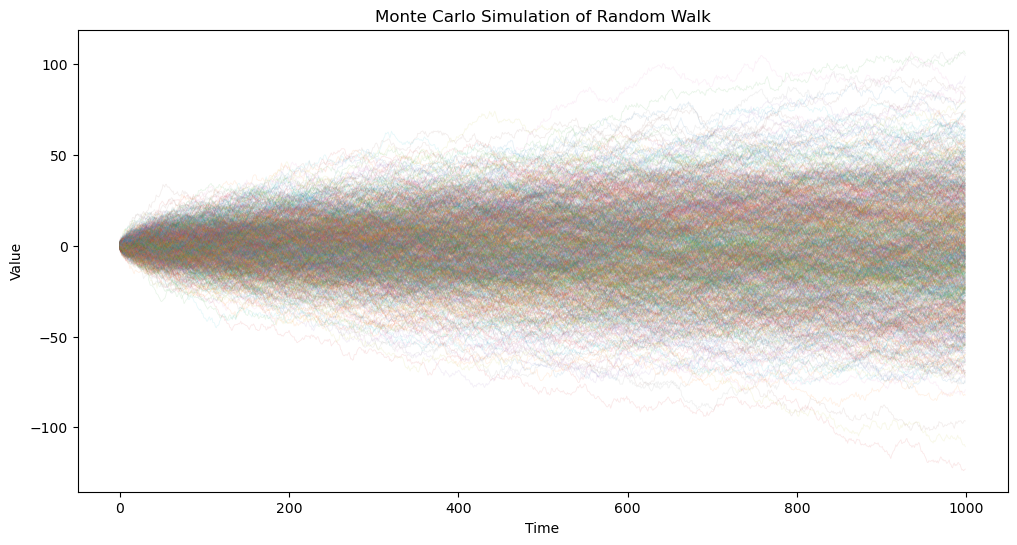

In [10]:
def plot_monte_carlo_simulation(simulated_series):
    plt.figure(figsize=(12, 6))
    for simulation in simulated_series:
        plt.plot(simulation, linewidth=0.6, alpha=0.1)
    plt.title('Monte Carlo Simulation of Random Walk')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

# Plot the results
plot_monte_carlo_simulation(simulated_series)

## Market Data Analysis

We'll fetch market data for a specific stock ticker and analyze it.

In [ ]:
# Fetch MES data (Micro E-mini S&P 500 futures)
ticker = 'MES=F'
benchmark_ticker = '^GSPC'  # S&P 500 index as benchmark
data = yf.download(ticker, interval='1d', period='10y')
benchmark_data = yf.download(benchmark_ticker, interval='1d', period='10y')

# Calculate 10 SMA
data['SMA_10'] = data['Close'].rolling(window=10).mean()

# Drop rows with NaN values (incomplete data for SMAs)
data.dropna(inplace=True)
benchmark_data = benchmark_data.loc[data.index[0]:data.index[-1]]  # Align benchmark data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## ARIMA Model Implementation 
This section demonstrates how to integrate the ARIMA model into the existing trading strategy.

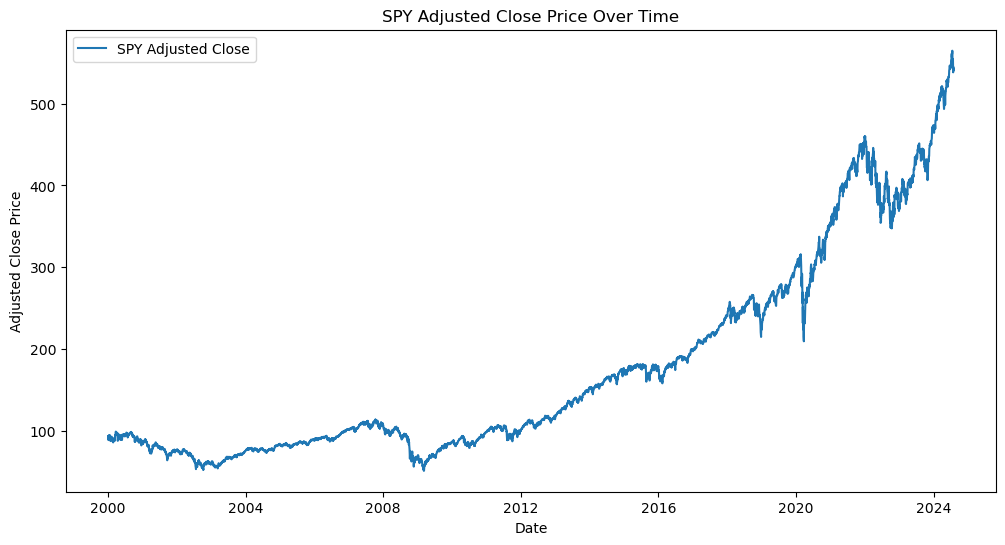

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the SPY data
spy_data = pd.read_csv(r'C:\Users\pc\Downloads\SPY.csv')

# Ensure the Date column is in datetime format and set it as the index
spy_data['Date'] = pd.to_datetime(spy_data['Date'])
spy_data.set_index('Date', inplace=True)

# Set the frequency of the date index
spy_data = spy_data.asfreq('B')  # 'B' stands for business day frequency

# Fill any missing values that may result from reindexing
spy_data['Adj Close'] = spy_data['Adj Close'].ffill()

# Select the adjusted close prices
adj_close_prices = spy_data['Adj Close']

# Plot the adjusted close prices to visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(adj_close_prices, label='SPY Adjusted Close')
plt.title('SPY Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Check for stationary auto-correlation ACF and partial auto-correlation PACF

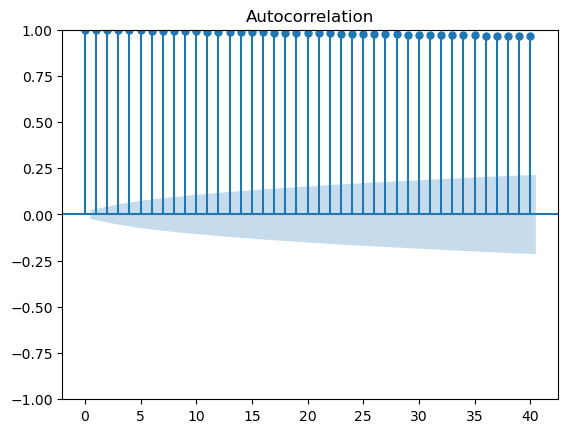

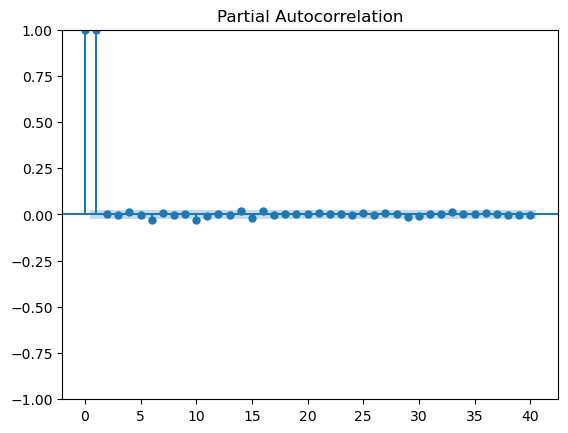

In [6]:
plot_acf(adj_close_prices, lags=40)
plt.show()
plot_pacf(adj_close_prices, lags=40)
plt.show()

# Fit an ARIMA model (adjust the order based on ACF/PACF analysis)

In [7]:

model = ARIMA(adj_close_prices, order=(1, 1, 1))  # Example order, adjust based on analysis
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 6412
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14332.942
Date:                Tue, 30 Jul 2024   AIC                          28671.884
Time:                        17:44:35   BIC                          28692.182
Sample:                    01-03-2000   HQIC                         28678.909
                         - 07-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2468      0.059     -4.218      0.000      -0.361      -0.132
ma.L1          0.1797      0.060      2.986      0.003       0.062       0.298
sigma2         5.1217      0.031    167.457      0.0

## Create a simple Trend-Following Strategy

We'll implement a simple moving average crossover strategy and back-test it on historical data.

In [ ]:
# Define the Trading Strategy
class TradingStrategy:
    def __init__(self, data, portfolio_value):
        self.data = data
        self.portfolio_value = portfolio_value
        self.position = 0
        self.entry_price = 0
        self.stop_loss = 0
        self.take_profit = 0
        self.trades = []
        self.monthly_volume = 0
        self.current_month = None
        
    def calculate_commission(self, quantity):
        # Update monthly volume
        current_month = self.data.index[-1].to_period('M')
        if current_month != self.current_month:
            self.monthly_volume = 0
            self.current_month = current_month
        
        self.monthly_volume += quantity
        
        # Determine commission tier
        if self.monthly_volume <= 1000:
            commission_per_contract = 0.25
        elif self.monthly_volume <= 10000:
            commission_per_contract = 0.20
        elif self.monthly_volume <= 20000:
            commission_per_contract = 0.15
        else:
            commission_per_contract = 0.10
        
        # Add exchange and regulatory fees (assumed to be constant)
        total_fee_per_contract = commission_per_contract + 0.20  # Assuming $0.20 for exchange and regulatory fees
        
        return total_fee_per_contract * quantity

    def evaluate_signals(self):
        for index, row in self.data.iterrows():
            if self.position == 0 and row['Close'] <= row['SMA_10']:
                self.entry_price = row['Close']
                self.stop_loss = row['SMA_10'] * 0.98  # 2% below the 10 SMA
                self.take_profit = row['SMA_10'] * 1.05  # 5% above the 10 SMA
                contract_size = 5  # Micro E-mini S&P 500 futures contract size
                self.position = int((self.portfolio_value * 0.10) / (self.entry_price * contract_size))  # Use 10% of portfolio
                if self.position < 1:
                    self.position = 1  # Minimum 1 contract
                commission = self.calculate_commission(self.position)
                self.trades.append({
                    'type': 'buy', 
                    'price': self.entry_price, 
                    'quantity': self.position, 
                    'date': index,
                    'commission': commission
                })
            elif self.position > 0 and (row['Close'] >= self.take_profit or row['Close'] <= self.stop_loss):
                commission = self.calculate_commission(self.position)
                self.trades.append({
                    'type': 'sell', 
                    'price': row['Close'], 
                    'quantity': self.position, 
                    'date': index,
                    'commission': commission
                })
                self.position = 0

    def get_trades(self):
        return self.trades


## Run the Strategy


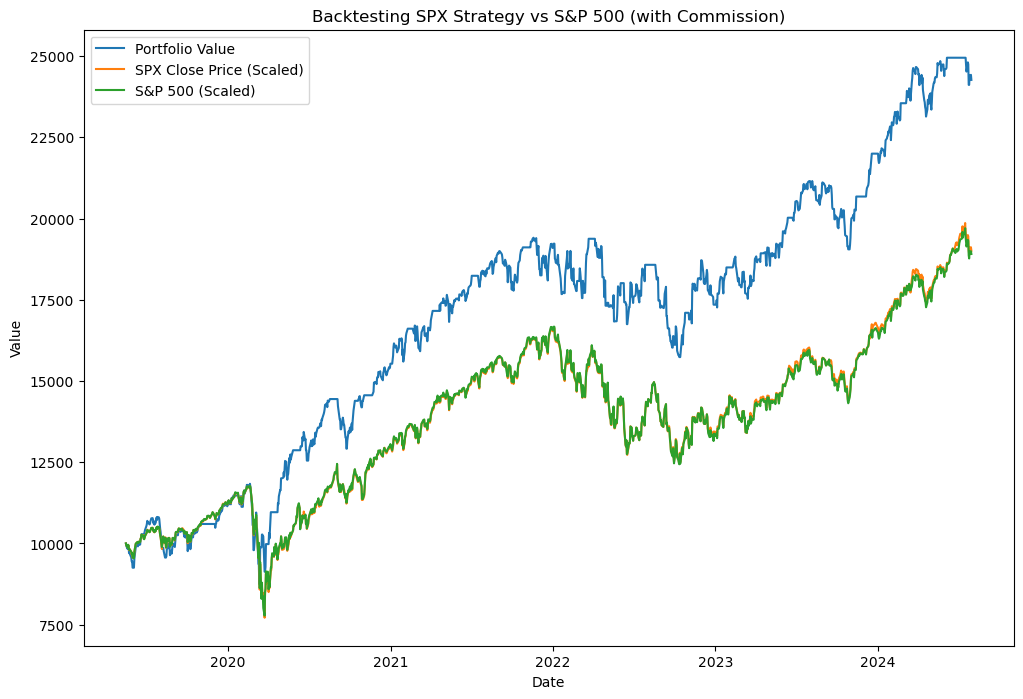

In [ ]:
# Initialize strategy
portfolio_value = 10000  # Example portfolio value
strategy = TradingStrategy(data, portfolio_value)
strategy.evaluate_signals()

# Display trades
trades = strategy.get_trades()
trades_df = pd.DataFrame(trades)

# Backtest the strategy
def backtest_strategy(data, trades):
    portfolio_value = 10000  # Starting portfolio value
    cash = portfolio_value
    contracts = 0
    portfolio_values = []
    contract_size = 5  # E-mini S&P 500 futures contract size
    for index, row in data.iterrows():
        if trades and trades[0]['date'] == index:
            trade = trades.pop(0)
            if trade['type'] == 'buy':
                contracts += trade['quantity']
                cash -= (trade['quantity'] * contract_size * trade['price'] + trade['commission'])
            elif trade['type'] == 'sell':
                contracts -= trade['quantity']
                cash += (trade['quantity'] * contract_size * trade['price'] - trade['commission'])
        portfolio_values.append(cash + contracts * contract_size * row['Close'])
    return np.array(portfolio_values)

portfolio_values = backtest_strategy(data, trades.copy())
data['Portfolio Value'] = portfolio_values

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(data.index, portfolio_values, label='Portfolio Value')
plt.plot(data.index, data['Close'] * (portfolio_values[0] / data['Close'].iloc[0]), label='SPX Close Price (Scaled)')
plt.plot(benchmark_data.index, benchmark_data['Close'] * (portfolio_values[0] / benchmark_data['Close'].iloc[0]), label='S&P 500 (Scaled)')
plt.title('Backtesting SPX Strategy vs S&P 500 (with Commission)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


## Calculate Performance Metrics

In [ ]:
# Calculate performance metrics
def calculate_performance_metrics(portfolio_values, benchmark_values):
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    
    # Total Return
    total_return = (final_value - initial_value) / initial_value * 100
    
    # Annualized Return
    years = len(portfolio_values) / 252  # Assuming 252 trading days per year
    annualized_return = ((final_value / initial_value) ** (1 / years) - 1) * 100
    
    # Daily Returns
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Sharpe Ratio
    sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
    
    # Maximum Drawdown
    cumulative_returns = np.cumprod(1 + daily_returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdowns = (peak - cumulative_returns) / peak
    max_drawdown = drawdowns.max() * 100
    
    # Beta
    benchmark_returns = np.diff(benchmark_values) / benchmark_values[:-1]
    # Ensure the lengths match
    min_length = min(len(daily_returns), len(benchmark_returns))
    daily_returns = daily_returns[:min_length]
    benchmark_returns = benchmark_returns[:min_length]
    beta, _ = stats.linregress(benchmark_returns, daily_returns)[:2]
    
    # Alpha
    risk_free_rate = 0.02  # Assuming 2% risk-free rate
    market_return = (benchmark_values[-1] / benchmark_values[0]) ** (1 / years) - 1
    alpha = annualized_return / 100 - (risk_free_rate + beta * (market_return - risk_free_rate))
    alpha *= 100  # Convert to percentage
    
    # Value at Risk (VaR)
    VaR_95 = np.percentile(daily_returns, 5) * portfolio_values[-1]
    
    # Conditional Value at Risk (CVaR)
    CVaR_95 = np.mean(daily_returns[daily_returns <= VaR_95]) * portfolio_values[-1] if len(daily_returns[daily_returns <= VaR_95]) > 0 else np.nan
    
    # Win Rate
    win_rate = (len(daily_returns[daily_returns > 0]) / len(daily_returns)) * 100
    
    # Profit Factor
    aligned_portfolio_values = portfolio_values[1:len(daily_returns) + 1]
    gross_profit = np.sum(daily_returns[daily_returns > 0] * aligned_portfolio_values[daily_returns > 0])
    gross_loss = np.sum(-daily_returns[daily_returns < 0] * aligned_portfolio_values[daily_returns < 0])
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan
    
    # Calmar Ratio
    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else np.nan
    
    # Recovery Factor
    recovery_factor = total_return / max_drawdown if max_drawdown != 0 else np.nan
    
    # Information Ratio
    tracking_error = np.std(daily_returns - benchmark_returns)
    information_ratio = (daily_returns.mean() - benchmark_returns.mean()) / tracking_error * np.sqrt(252) if tracking_error != 0 else np.nan
    
    # Omega Ratio
    threshold_return = 0
    gains = daily_returns[daily_returns > threshold_return]
    losses = -daily_returns[daily_returns <= threshold_return]
    omega_ratio = gains.sum() / losses.sum() if losses.sum() != 0 else np.nan
    
    # Kurtosis and Skewness
    kurtosis = stats.kurtosis(daily_returns)
    skewness = stats.skew(daily_returns)
    
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Beta': beta,
        'Alpha': alpha,
        'Value at Risk (VaR)': VaR_95,
        'Conditional Value at Risk (CVaR)': CVaR_95,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor,
        'Calmar Ratio': calmar_ratio,
        'Recovery Factor': recovery_factor,
        'Information Ratio': information_ratio,
        'Omega Ratio': omega_ratio,
        'Kurtosis': kurtosis,
        'Skewness': skewness
    }

# Calculate performance metrics
metrics = calculate_performance_metrics(portfolio_values, benchmark_data['Close'].values)

# Print performance metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

Total Return: 142.67
Annualized Return: 18.58
Sharpe Ratio: 0.94
Maximum Drawdown: 26.12
Beta: 0.71
Alpha: 8.78
Value at Risk (VaR): -421.53
Conditional Value at Risk (CVaR): nan
Win Rate: 39.80
Profit Factor: 1.26
Calmar Ratio: 0.71
Recovery Factor: 5.46
Information Ratio: 0.31
Omega Ratio: 1.23
Kurtosis: 18.79
Skewness: -0.06


## Save the Results in a CSV file.

In [ ]:
# Create trade log CSV
trade_log = pd.DataFrame(trades)
trade_log['return'] = trade_log.groupby(['type'])['price'].pct_change().fillna(0)
trade_log['cumulative_return'] = (1 + trade_log['return']).cumprod() - 1
trade_log.to_csv('trade_log_with_commission.csv', index=False)

print("Trade log saved to 'trade_log_with_commission.csv'")

# Calculate total commission paid
total_commission = trades_df['commission'].sum()
print(f"Total commission paid: ${total_commission:.2f}")

Trade log saved to 'trade_log_with_commission.csv'
Total commission paid: $108.90
